Heart Failure Prediction Model Training

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset (1).csv')

In [28]:
 df.shape

(299, 13)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [30]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [31]:
# Check for missing values
df.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [32]:
# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df['DEATH_EVENT'].value_counts())
print(f"Death Event Rate: {df['DEATH_EVENT'].mean():.2%}")


Target Variable Distribution:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Death Event Rate: 32.11%


Exploratory Data Analysis

Text(0, 0.5, 'Count')

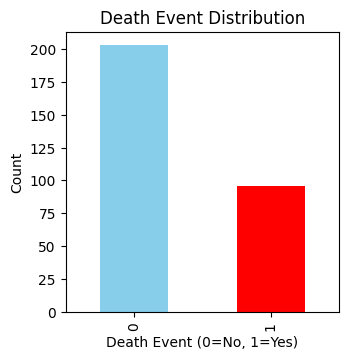

In [33]:
# Target variable distribution
plt.figure(figsize=(12, 8)) # Increase figure size
plt.subplot(2, 3, 1)
df['DEATH_EVENT'].value_counts().plot(kind='bar', color=['skyblue', 'red'])
plt.title('Death Event Distribution')
plt.xlabel('Death Event (0=No, 1=Yes)')
plt.ylabel('Count')

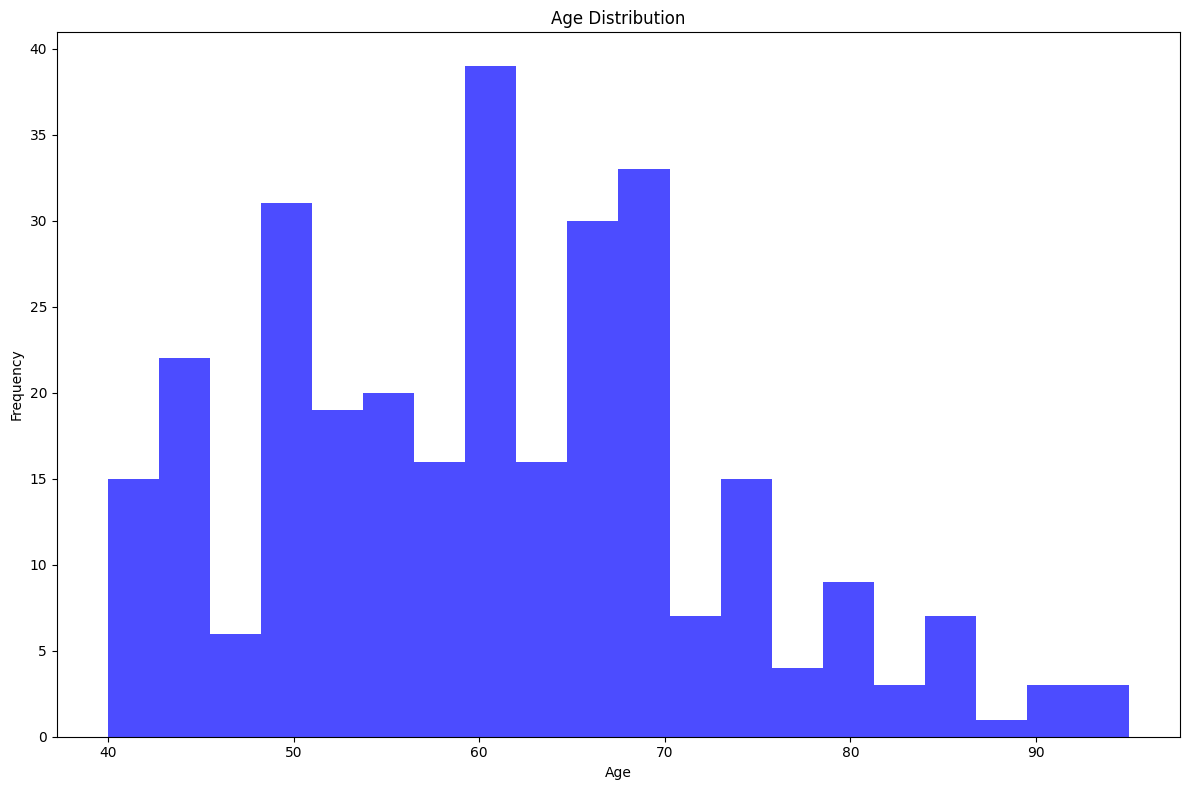

In [34]:
# Age distribution
plt.figure(figsize=(12, 8)) # Increase figure size
plt.hist(df['age'], bins=20, alpha=0.7, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

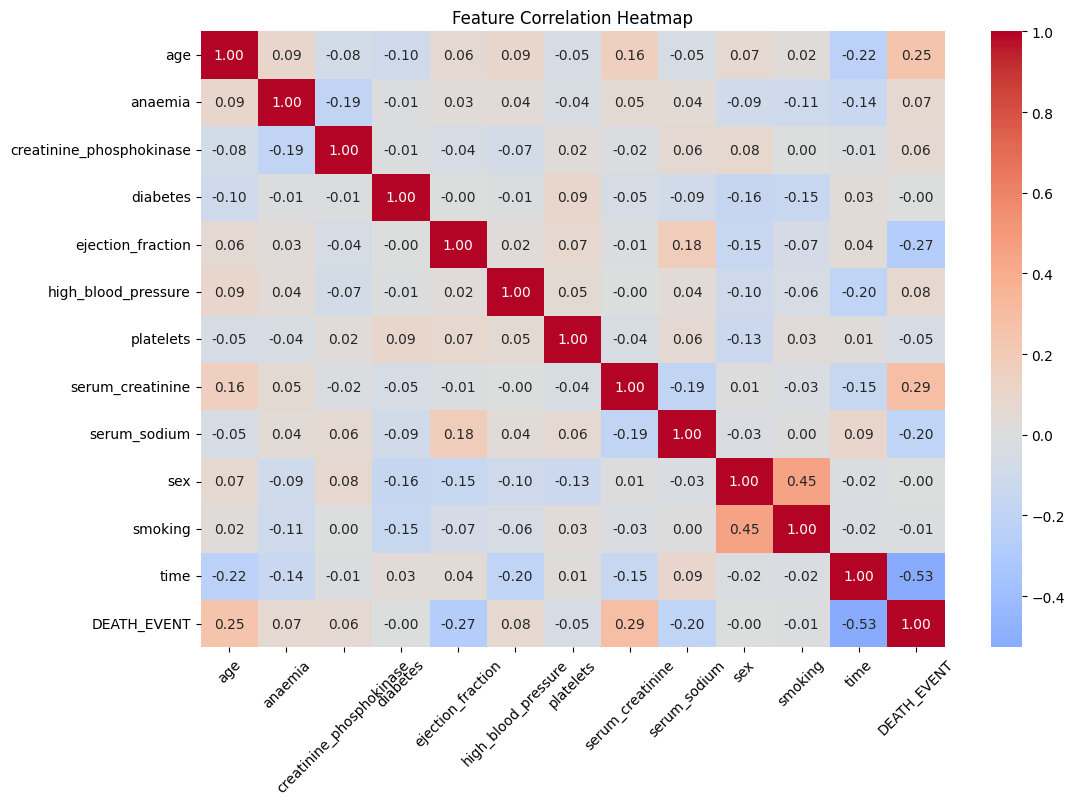

In [35]:
# Correlation heatmap
plt.figure(figsize=(12, 8)) # Increase figure size
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.xticks(rotation=45)
plt.title('Feature Correlation Heatmap')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'time'),
  Text(1, 0, 'serum_creatinine'),
  Text(2, 0, 'ejection_fraction'),
  Text(3, 0, 'age'),
  Text(4, 0, 'serum_sodium'),
  Text(5, 0, 'high_blood_pressure'),
  Text(6, 0, 'anaemia'),
  Text(7, 0, 'creatinine_phosphokinase'),
  Text(8, 0, 'platelets'),
  Text(9, 0, 'smoking'),
  Text(10, 0, 'sex'),
  Text(11, 0, 'diabetes')])

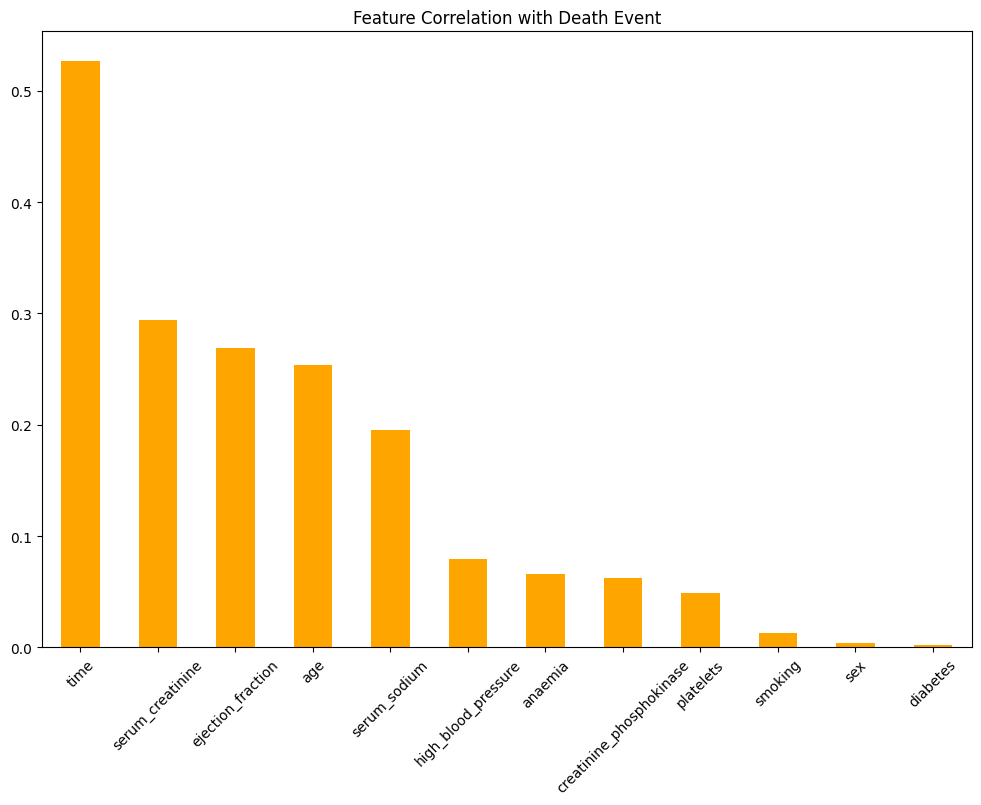

In [36]:
# Feature importance analysis
plt.figure(figsize=(12, 8)) # Increase figure size
death_corr = df.corr()['DEATH_EVENT'].abs().sort_values(ascending=False)[1:]
death_corr.plot(kind='bar', color='orange')
plt.title('Feature Correlation with Death Event')
plt.xticks(rotation=45)

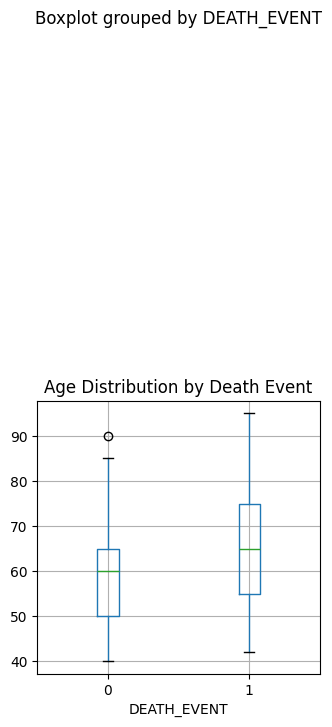

In [37]:
# Age vs Death Event
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 5)
df.boxplot(column='age', by='DEATH_EVENT', ax=plt.gca())
plt.title('Age Distribution by Death Event')
plt.show()

In [38]:
# Prepare features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

print("\nFeature columns:")
print(X.columns.tolist())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Feature columns:
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']

Training set size: (239, 12)
Test set size: (60, 12)


In [39]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

In [40]:
# Train and evaluate models
results = {}
best_model = None
best_accuracy = 0
best_model_name = None
best_scaler = None

print("\nModel Performance Comparison:")
print("="*60)

for name, model in models.items():
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
        current_scaler = scaler
    else:
        X_train_use = X_train
        X_test_use = X_test
        current_scaler = None

    # Train the model
    model.fit(X_train_use, y_train)

    # Make predictions
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC Score: {auc_score:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-"*60)

    # Track best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name
        best_scaler = current_scaler

print(f"\nBest Model: {best_model_name} with accuracy: {best_accuracy:.4f}")


Model Performance Comparison:
Random Forest:
  Accuracy: 0.8333
  AUC Score: 0.8915
  CV Score: 0.8493 (+/- 0.0896)
  Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60

------------------------------------------------------------
Gradient Boosting:
  Accuracy: 0.8333
  AUC Score: 0.8447
  CV Score: 0.8495 (+/- 0.0884)
  Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60

----------------------------

In [41]:
# # Hyperparameter tuning for the best performing model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    print(f"\nTuning hyperparameters for {best_model_name}...")
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                               param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Use the best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Evaluate tuned model
    y_pred_tuned = best_model.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    print(f"Tuned model accuracy: {accuracy_tuned:.4f}")


Tuning hyperparameters for Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Tuned model accuracy: 0.8333



Feature Importance:
                     feature  importance
11                      time    0.399564
7           serum_creatinine    0.151432
4          ejection_fraction    0.134737
0                        age    0.076652
6                  platelets    0.067358
2   creatinine_phosphokinase    0.063963
8               serum_sodium    0.051051
3                   diabetes    0.012042
5        high_blood_pressure    0.011438
9                        sex    0.011238
10                   smoking    0.010524
1                    anaemia    0.010001


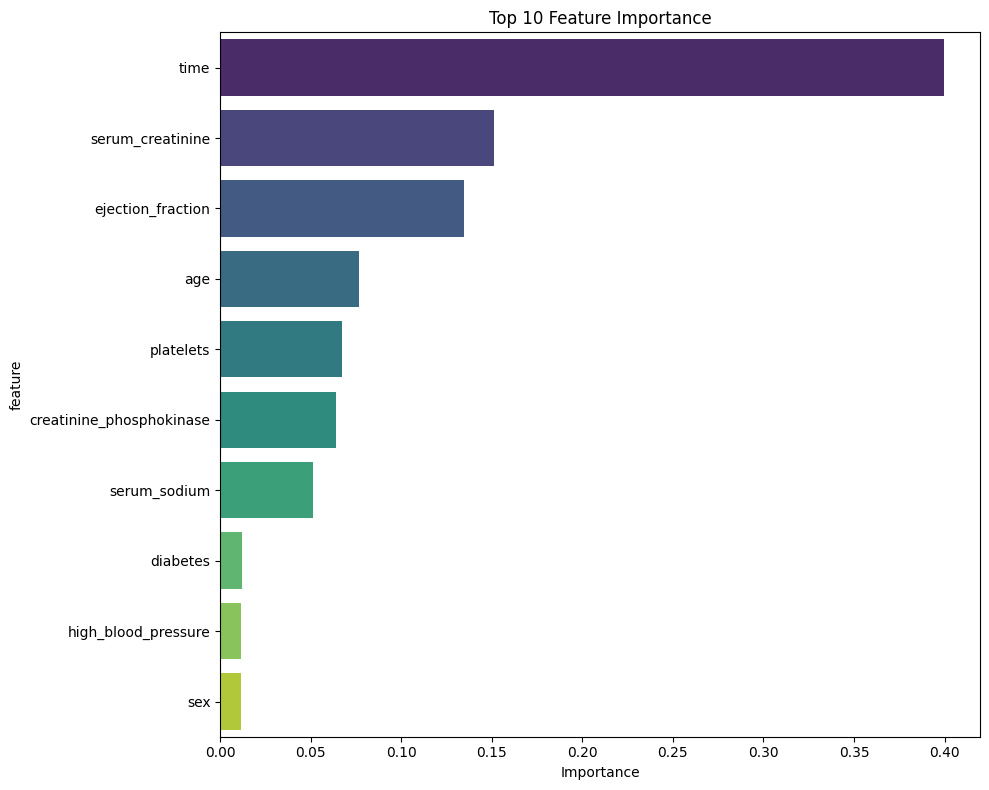

In [42]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


Final Model Performance:
Model: Random Forest
Accuracy: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



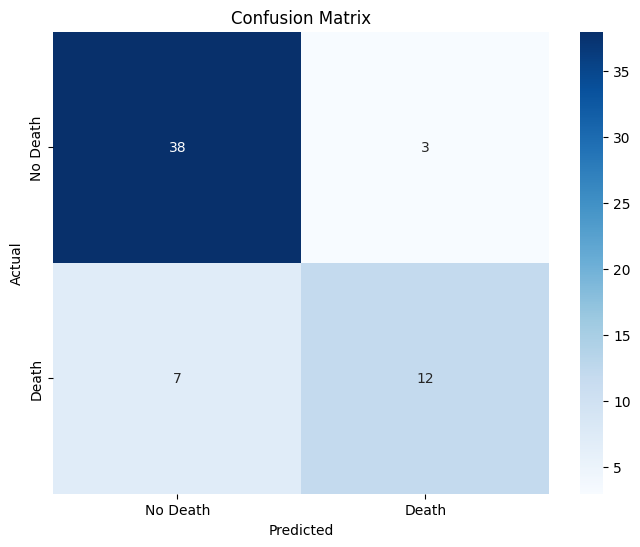

In [43]:
# Final model evaluation
y_pred_final = best_model.predict(X_test if best_scaler is None else X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\nFinal Model Performance:")
print(f"Model: {best_model_name}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Classification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Death', 'Death'],
            yticklabels=['No Death', 'Death'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
# Save the model and scaler
joblib.dump(best_model, 'heart_failure_model.pkl')
if best_scaler is not None:
    joblib.dump(best_scaler, 'scaler.pkl')

print(f"\nModel saved as 'heart_failure_model.pkl'")
if best_scaler is not None:
    print("Scaler saved as 'scaler.pkl'")


Model saved as 'heart_failure_model.pkl'


In [45]:
# Create feature names list for the Flask app
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("Feature names saved as 'feature_names.pkl'")

print(f"\nProject completed! Final accuracy: {final_accuracy:.4f}")
print(f"Achievement: {'✅ Above 80%' if final_accuracy >= 0.8 else '❌ Below 80%'}")

Feature names saved as 'feature_names.pkl'

Project completed! Final accuracy: 0.8333
Achievement: ✅ Above 80%
